In [114]:
import json
from pathlib import Path
from tqdm import tqdm
import random

import numpy as np
from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import segmentation_models_pytorch as smp
from torchmetrics import JaccardIndex, F1Score, Accuracy
from torchmetrics.segmentation import DiceScore

import matplotlib.pyplot as plt

## **Configs**

In [140]:
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

# Common configurations
NUM_CLASSES = 14
IMAGE_SIZE = (512, 512)
DATA_ROOT = Path("/Users/diegovelasco/Desktop/Diego/FING/DLFCV-FinalProject/data_clean")  # folder containing data_clean/

IMG_DIR = DATA_ROOT / "images"
MSK_DIR = DATA_ROOT / "masks"

train_img_dir = IMG_DIR / "train"
train_msk_dir = MSK_DIR / "train"

test_img_dir = IMG_DIR / "test"
test_msk_dir = MSK_DIR / "test"

# Per model configurations
# UNet
UNET_CKPT_PATH = Path("UNet/unet_best_miou.pth")
UNET_OUTPUT_JSON = Path("UNet/test_metrics.json")

# DeepLabV3+
DEEPLAB_CKPT_PATH = Path("DeepLabV3+/deeplab_best_miou.pth")
DEEPLAB_OUTPUT_JSON = Path("DeepLabV3+/test_metrics.json")

# SegFormer
SEGFORMER_CKPT_PATH = Path("SegFormer/segformer_best_miou.pth")
SEGFORMER_OUTPUT_JSON = Path("SegFormer/test_metrics.json")

True
True
Using device: mps


In [ ]:
# Dataset setup
class Dacl10kDataset(Dataset):
    def __init__(self, img_dir, msk_dir, image_size=(512, 512)):
        self.img_dir = Path(img_dir)
        self.msk_dir = Path(msk_dir)
        self.image_size = image_size

        self.img_paths = sorted([p for p in self.img_dir.iterdir()])

        # Transformations for training images
        self.img_transform = transforms.Compose([
            transforms.Resize(self.image_size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor(),
            transforms.Normalize(  # Normalize each channel with ImageNet normalization values
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])

        self.mask_resize = transforms.Resize(
            self.image_size,
            interpolation=transforms.InterpolationMode.NEAREST, # Change interpolation value to keep integers
        )

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        msk_path = self.msk_dir / img_path.name.replace("jpg", "png") # same filename, jpg -> png

        # Image
        img = Image.open(img_path).convert("RGB")
        img = self.img_transform(img)

        # Mask
        mask = Image.open(msk_path)
        mask = self.mask_resize(mask)
        mask = torch.from_numpy(np.array(mask, dtype=np.int64))  # [H, W] long with 0..13

        return img, mask
        

# Function to evaluate a model
def eval_model_on_loader(model, loader, num_classes, device, OUTPUT_JSON):
    model.eval()

    # Define metrics (per class)
    miou_metric = JaccardIndex(
        task="multiclass",
        num_classes=num_classes,
        average=None,
    ).to(device)


    dice_metric = DiceScore(
        num_classes=num_classes,
        include_background=True,      # or False if you want to drop class 0
        average="none",               # per-class
        input_format="index",         # <-- IMPORTANT
        aggregation_level="global",   # accumulate over dataset
    ).to(device)


    f1_metric = F1Score(
        task="multiclass",
        num_classes=num_classes,
        average=None,
    ).to(device)

    acc_metric = Accuracy(
        task="multiclass",
        num_classes=num_classes,
    ).to(device)

    # Reset metrics
    miou_metric.reset()
    dice_metric.reset()
    f1_metric.reset()
    acc_metric.reset()

    # Run a full pass over the loader and update metrics
    with torch.no_grad():
        for images, masks in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            masks  = masks.to(device)

            logits = model(images)
            preds  = torch.argmax(logits, dim=1)

            miou_metric.update(preds, masks)
            dice_metric.update(preds, masks)
            f1_metric.update(preds, masks)
            acc_metric.update(preds, masks)

    per_class_iou = miou_metric.compute().cpu().tolist()
    per_class_dice = dice_metric.compute().cpu().tolist()
    per_class_f1 = f1_metric.compute().cpu().tolist()
    global_acc = acc_metric.compute().item()

    mean_iou = float(np.mean(per_class_iou))
    macro_dice = float(np.mean(per_class_dice))
    macro_f1 = float(np.mean(per_class_f1))

    # Save results to JSON
    results = {
        "per_class_iou": per_class_iou,
        "per_class_dice": per_class_dice,
        "per_class_f1": per_class_f1,
        "mean_iou": mean_iou,
        "macro_dice": macro_dice,
        "macro_f1": macro_f1,
        "global_pixel_accuracy": float(global_acc),
    }

    with open(OUTPUT_JSON, "w") as f:
        json.dump(results, f, indent=2)

    return results

In [141]:
# Train
train_dataset = Dacl10kDataset(train_img_dir, train_msk_dir, IMAGE_SIZE)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, num_workers=0)
print("Train samples:", len(train_dataset), "| batches:", len(train_loader))

# Test
test_dataset = Dacl10kDataset(test_img_dir, test_msk_dir, IMAGE_SIZE)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)
print("Test samples:", len(test_dataset), "| batches:", len(test_loader))

Train samples: 5895 | batches: 737
Test samples: 975 | batches: 244


## **Results**

In [94]:
# Run evaluation on test set and save results
# UNet
unet_test_results = eval_model_on_loader(
    unet,
    test_loader,
    NUM_CLASSES,
    device,
    UNET_OUTPUT_JSON,
)

# DeepLabV3+
deeplab_test_results = eval_model_on_loader(
    deeplab,
    test_loader,
    NUM_CLASSES,
    device,
    DEEPLAB_OUTPUT_JSON,
)

Evaluating: 100%|██████████| 244/244 [01:00<00:00,  4.06it/s]


torch.Size([14])
tensor(0.) tensor(0.8900)


Evaluating: 100%|██████████| 244/244 [01:08<00:00,  3.58it/s]

torch.Size([14])
tensor(0.1262) tensor(0.8932)


In [106]:
# Load train and validation results
# UNet
with open('UNet/unet_results.json', 'r') as f:
    unet_train_results = json.load(f)

# DeepLabV3+
with open('DeepLabV3+/deeplab_results.json', 'r') as f:
    deeplab_train_results = json.load(f)

### **Global results**

In [102]:
def extract_metrics(train_results, test_results):
    history = train_results['history']
    epochs = [h['epoch'] for h in history]

    # Train metrics
    train_losses = [h['train_loss_eval'] for h in history]
    train_miou = [h['train_miou'] for h in history]
    train_dice = [h['train_dice'] for h in history]
    train_f1 = [h['train_f1_macro'] for h in history]
    train_accuracy = [h['train_global_pixel_accuracy'] for h in history]

    train_metrics = {
        'Loss': train_losses,
        'mIoU': train_miou,
        #'Dice Score': train_dice, implemented incorrectly during training
        'F1 Macro Score': train_f1,
        'Pixel Accuracy': train_accuracy
    }

    # Validation metrics
    val_losses = [h['val_loss'] for h in history]
    val_miou = [h['val_miou'] for h in history]
    val_dice = [h['val_dice'] for h in history]
    val_f1 = [h['val_f1_macro'] for h in history]
    val_accuracy = [h['val_global_pixel_accuracy'] for h in history]

    val_metrics = {
        'Loss': val_losses,
        'mIoU': val_miou,
        #'Dice Score': val_dice, implemented incorrectly during training
        'F1 Macro Score': val_f1,
        'Pixel Accuracy': val_accuracy
    }

    # Test metrics (global)
    test_metrics = {
        'Loss': None, # placeholder for easier plotting
        'mIoU': test_results['mean_iou'],
        #'Dice Score': test_results['macro_dice'], implemented incorrectly during training
        'F1 Macro Score': test_results['macro_f1'],
        'Pixel Accuracy': test_results['global_pixel_accuracy'],
    }

    return epochs, train_metrics, val_metrics, test_metrics


In [103]:
# Visualize global results
def plot_metrics(epochs, train_metrics, val_metrics, test_metrics, title):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    axes = ax.flatten()
    for ax, train_metric, val_metric, test_metric in zip(axes, train_metrics, val_metrics, test_metrics):
        ax.plot(epochs, train_metrics[train_metric], label="Train")   
        if train_metric != 'Loss':
            ax.plot(epochs, val_metrics[val_metric], label="Validation")
            ax.scatter(epochs[-1], test_metrics[test_metric], c='r', label="Test")
            ax.legend(loc="lower right")
        ax.set_xlabel("Epoch")
        ax.set_title(train_metric if train_metric != "Loss" else "Training Loss")
        ax.grid(alpha=0.5)

    fig.suptitle(title)
    plt.show()

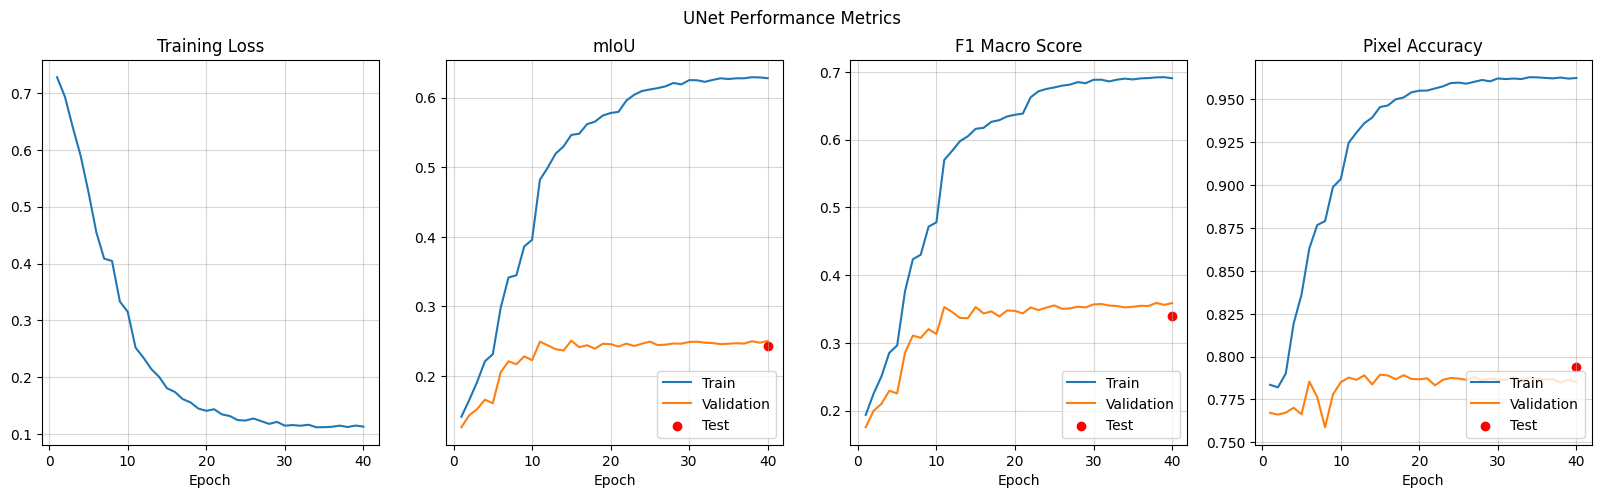

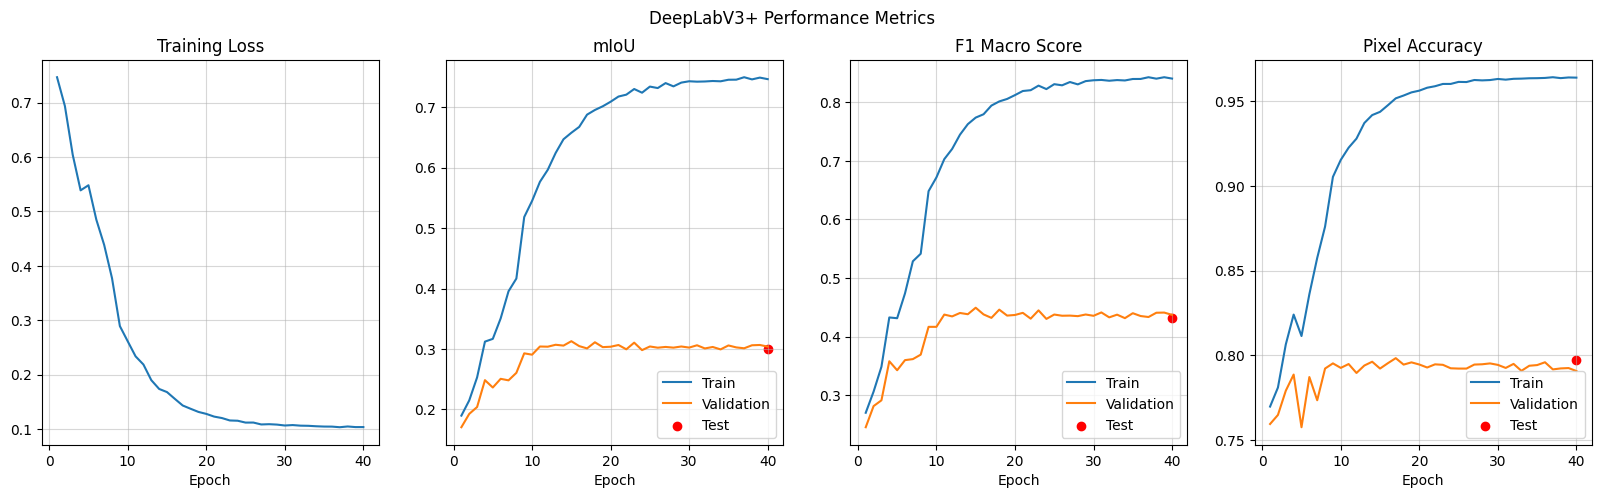

In [104]:
# Plot results
epochs, unet_train_metrics, unet_val_metrics, unet_test_metrics = extract_metrics(unet_train_results, unet_test_results)
plot_metrics(epochs, unet_train_metrics, unet_val_metrics, unet_test_metrics, "UNet Performance Metrics")
epochs, deeplab_train_metrics, deeplab_val_metrics, deeplab_test_metrics = extract_metrics(deeplab_train_results, deeplab_test_results)
plot_metrics(epochs, deeplab_train_metrics, deeplab_val_metrics, deeplab_test_metrics, "DeepLabV3+ Performance Metrics")

### **Per class results**

In [ ]:
def plot_grouped_per_class_metric(class_names, per_class_metrics, metric_key="mIoU"):
    """
    Plot grouped per-class metric bars for multiple models.
    
    Parameters:
    -----------
    class_names : list of str
        Names of classes (len = C)
    
    model_metrics : list of dict
        Each dict must contain:
            - 'name': model name (str)
            - metric_key: list of per-class values (len = C)
    
    metric_key : str
        Key to plot ('mIoU', 'Dice Score', 'F1 Macro Score')
    """

    num_classes = len(class_names)
    num_models  = len(per_class_metrics)

    x = np.arange(num_classes)
    width = 0.8 / num_models   # spread bars evenly

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, model in enumerate(per_class_metrics):
        values = model[metric_key]
        offset = (i - (num_models - 1) / 2) * width  # bar offset per model
        ax.bar(x + offset, values, width, label=model["name"])

    # Labels / formatting
    ax.set_ylabel(metric_key)
    ax.set_title(f"{metric_key} per class (Test Set)")
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)

    plt.tight_layout()
    plt.show()


In [112]:
# UNet
unet_per_class = {
    'name': 'UNet',
    'mIoU': unet_test_results["per_class_iou"],
    'Dice Score': unet_test_results["per_class_dice"],
    'F1 Macro Score': unet_test_results["per_class_f1"],
}

# DeepLabV3+
deeplab_per_class = {
    'name': 'DeepLabV3+',
    'mIoU': deeplab_test_results["per_class_iou"],
    'Dice Score': deeplab_test_results["per_class_dice"],
    'F1 Macro Score': deeplab_test_results["per_class_f1"],
}

# SegFormer


# Class Names (in order)
CLASS_NAMES = [
    'Background',
    'Crack', 'ExposedRebars', 'Spalling', 'Rust', 'ACrack',
    'Rockpocket', 'Hollowareas', 'Efflorescence', 'Cavity',
    'Wetspot', 'Weathering', 'Restformwork', 'Graffiti',
]

per_class_metrics = [unet_per_class, deeplab_per_class]

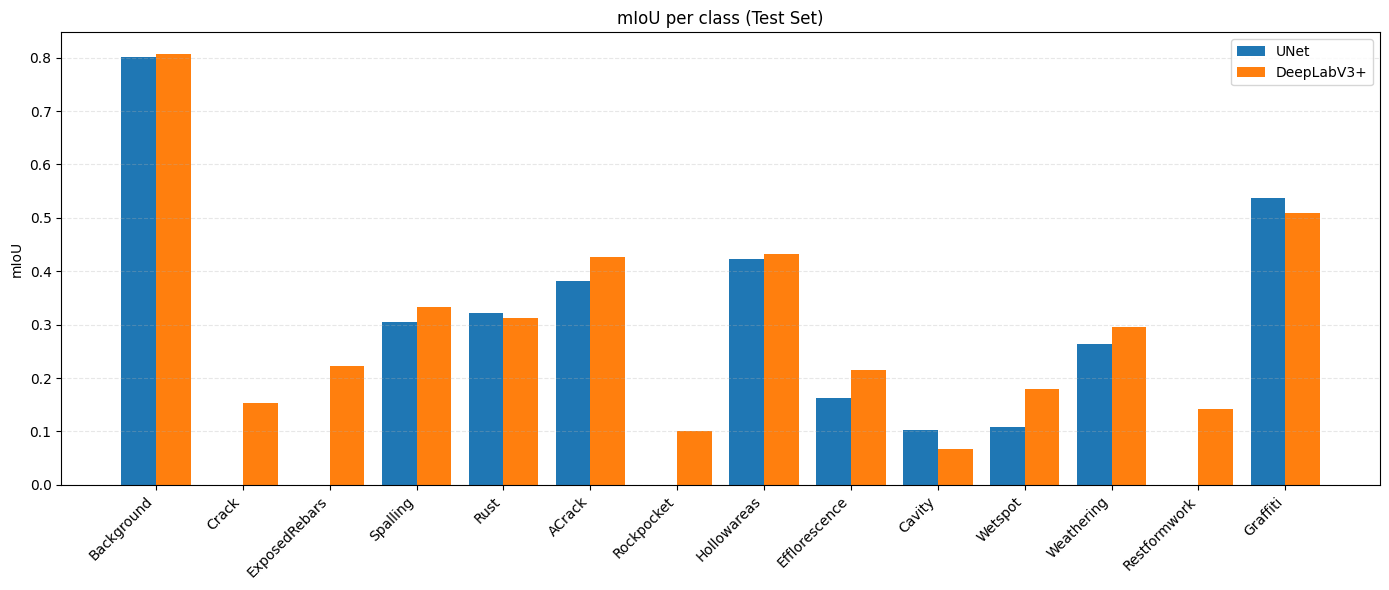

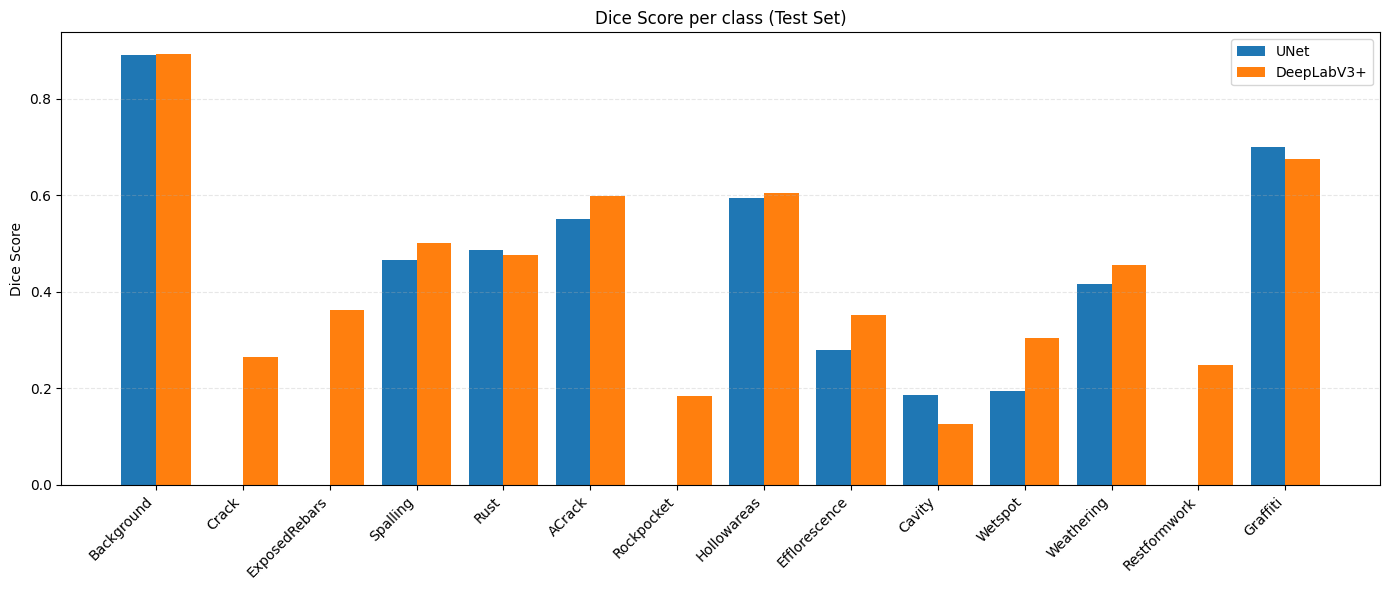

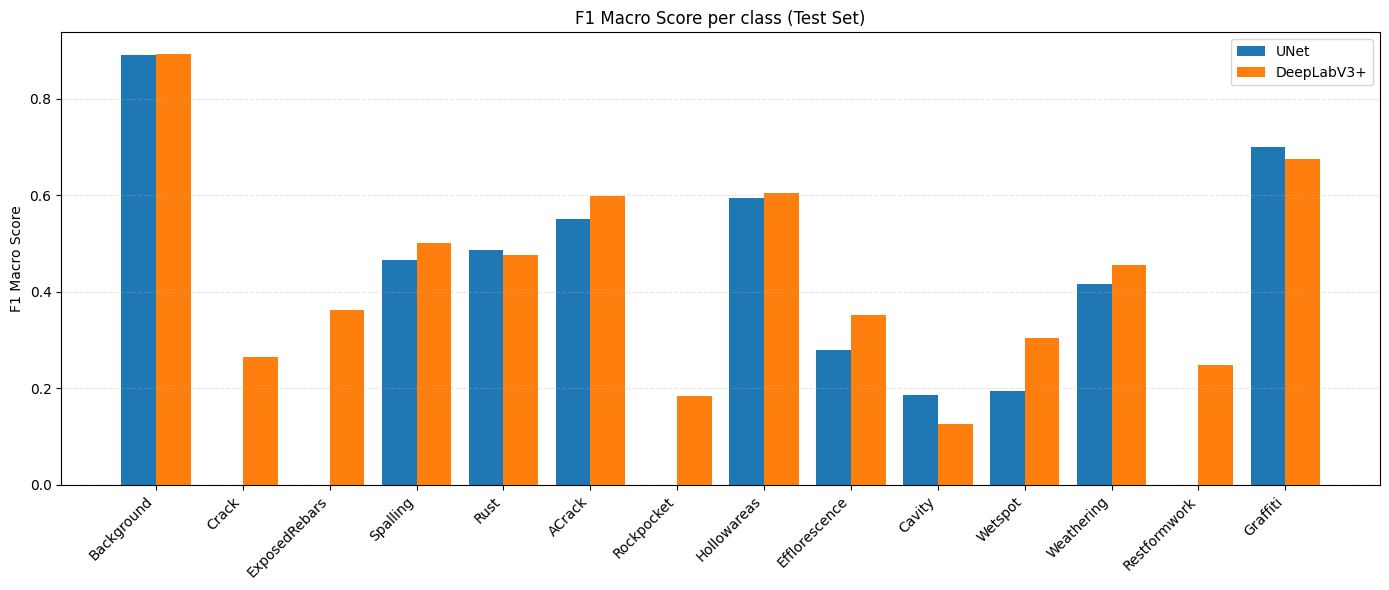

In [113]:
plot_grouped_per_class_metric(CLASS_NAMES, per_class_metrics, metric_key="mIoU")

# Dice comparison
plot_grouped_per_class_metric(CLASS_NAMES, per_class_metrics, metric_key="Dice Score")

# F1 comparison
plot_grouped_per_class_metric(CLASS_NAMES, per_class_metrics, metric_key="F1 Macro Score")

### **Visualize results**

In [134]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def visualize_random_sample_models(
    models_dict,
    dataset,
    device,
    class_names=None,
    num_classes=14
):
    """
    Randomly pick one sample and plot:
      Image | GT | Model1 | Model2 | ...
    Legend shows ONLY the classes present in GT or predictions.
    """
    for m in models_dict.values():
        m.eval()

    # ---- 1) Pick random sample
    idx = random.randint(0, len(dataset) - 1)
    img_tensor, gt_mask = dataset[idx]

    img_batch = img_tensor.unsqueeze(0).to(device)

    # ---- 2) Predictions
    preds = {}
    with torch.no_grad():
        for name, model in models_dict.items():
            logits = model(img_batch)
            pred = torch.argmax(logits, dim=1).squeeze(0).cpu().numpy()
            preds[name] = pred

    gt_np = gt_mask.numpy()

    # ---- 3) Denormalize image
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img_np = np.clip(img_np, 0, 1)

    # ---- 4) Identify classes actually present
    present_classes = set(np.unique(gt_np))
    for pred in preds.values():
        present_classes.update(np.unique(pred))

    present_classes = sorted(list(present_classes))

    # default names if not provided
    if class_names is None:
        class_names = [f"Class {i}" for i in range(num_classes)]

    # ---- 5) Plot
    n_models = len(models_dict)
    n_cols = 2 + n_models
    cmap = "tab20"
    vmax = num_classes - 1

    fig, axs = plt.subplots(1, n_cols, figsize=(5 * n_cols + 3, 5))

    axs[0].imshow(img_np)
    axs[0].set_title(f"Image (idx={idx})")
    axs[0].axis("off")

    axs[1].imshow(gt_np, vmin=0, vmax=vmax, cmap=cmap)
    axs[1].set_title("Ground Truth")
    axs[1].axis("off")

    col = 2
    for name, pred_mask in preds.items():
        axs[col].imshow(pred_mask, vmin=0, vmax=vmax, cmap=cmap)
        axs[col].set_title(f"{name}")
        axs[col].axis("off")
        col += 1

    # ---- 6) Legend only for displayed classes
    cmap_obj = plt.get_cmap(cmap)

    legend_handles = [
        Patch(facecolor=cmap_obj(c / num_classes), label=class_names[c])
        for c in present_classes
    ]

    fig.legend(
        handles=legend_handles,
        loc="lower right",
        #bbox_to_anchor=(1.02, 0.5),
        #borderaxespad=0.3,
    )

    plt.tight_layout()
    plt.show()


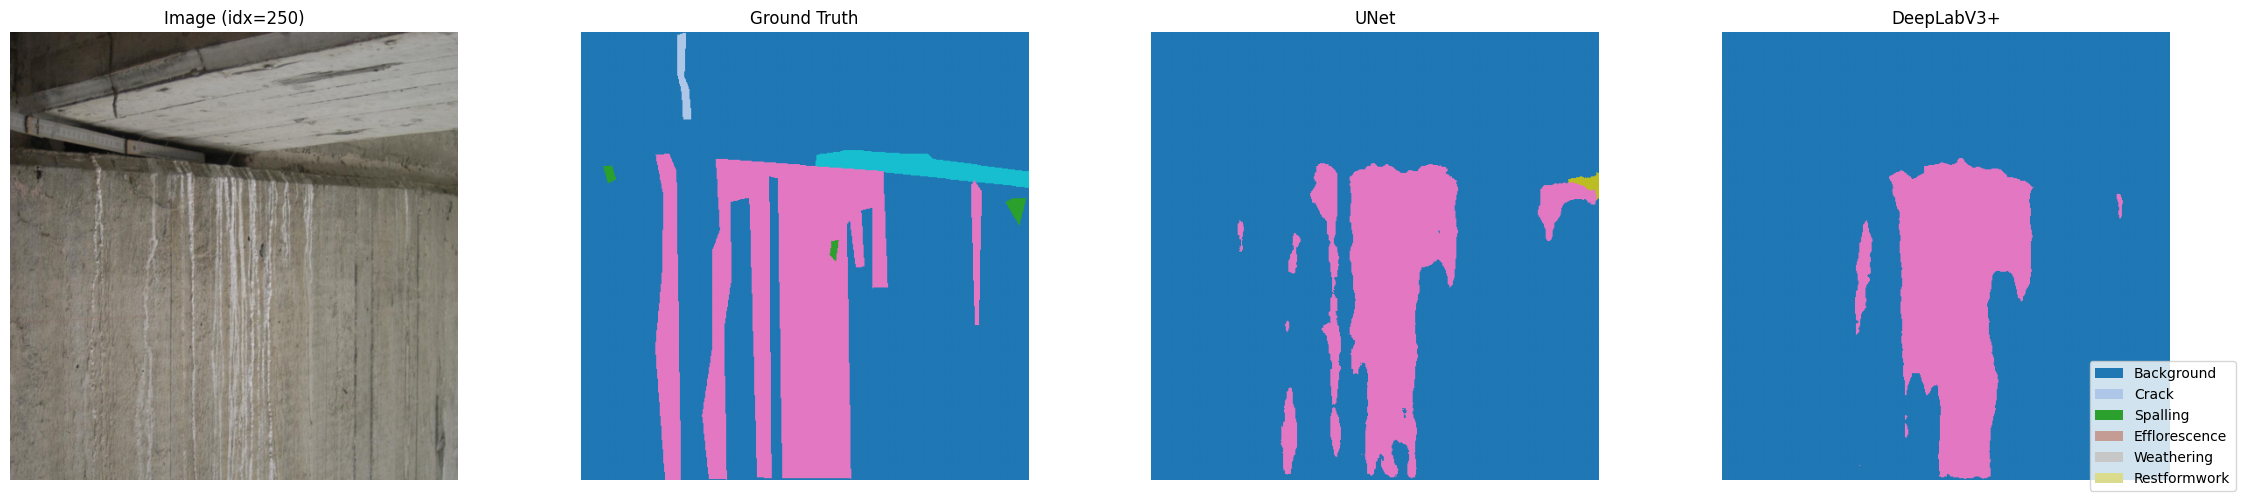

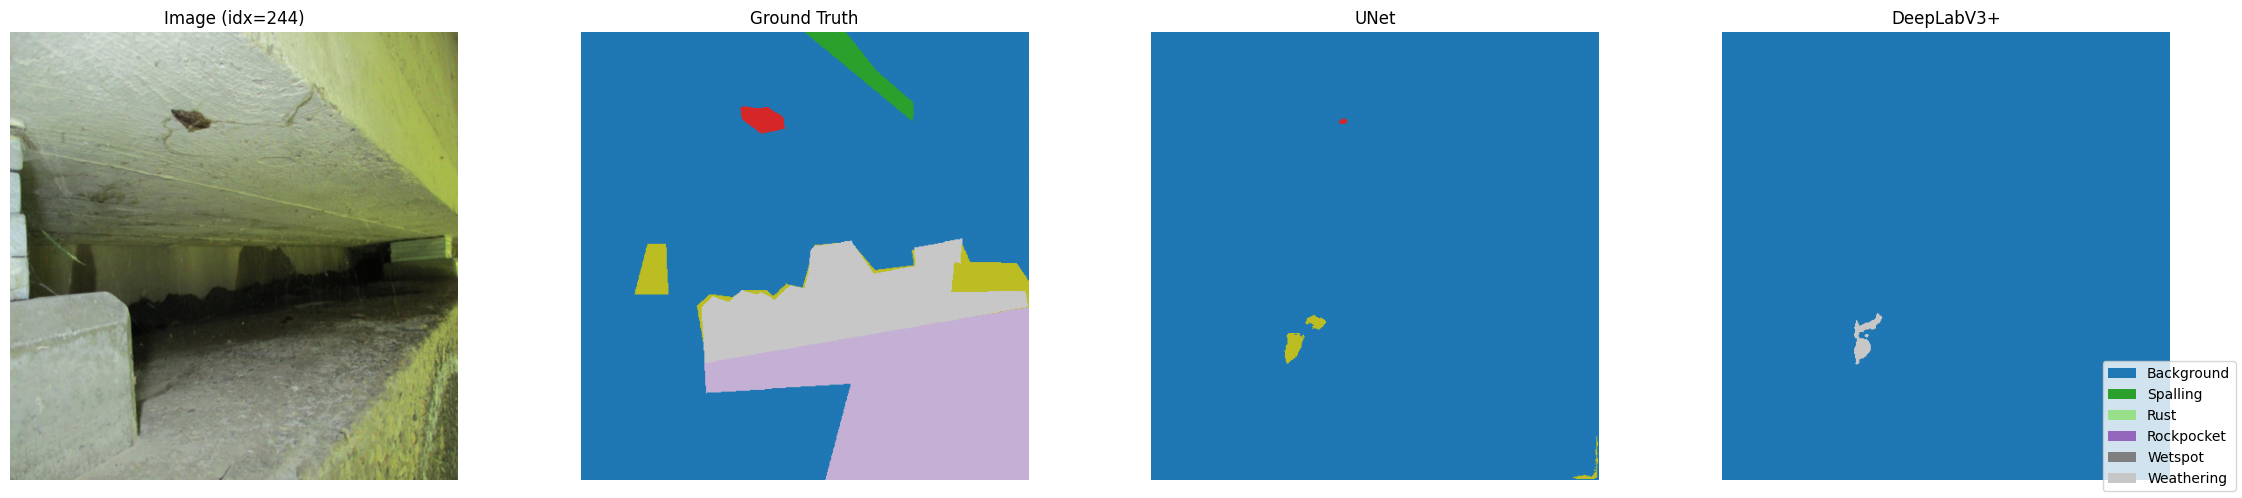

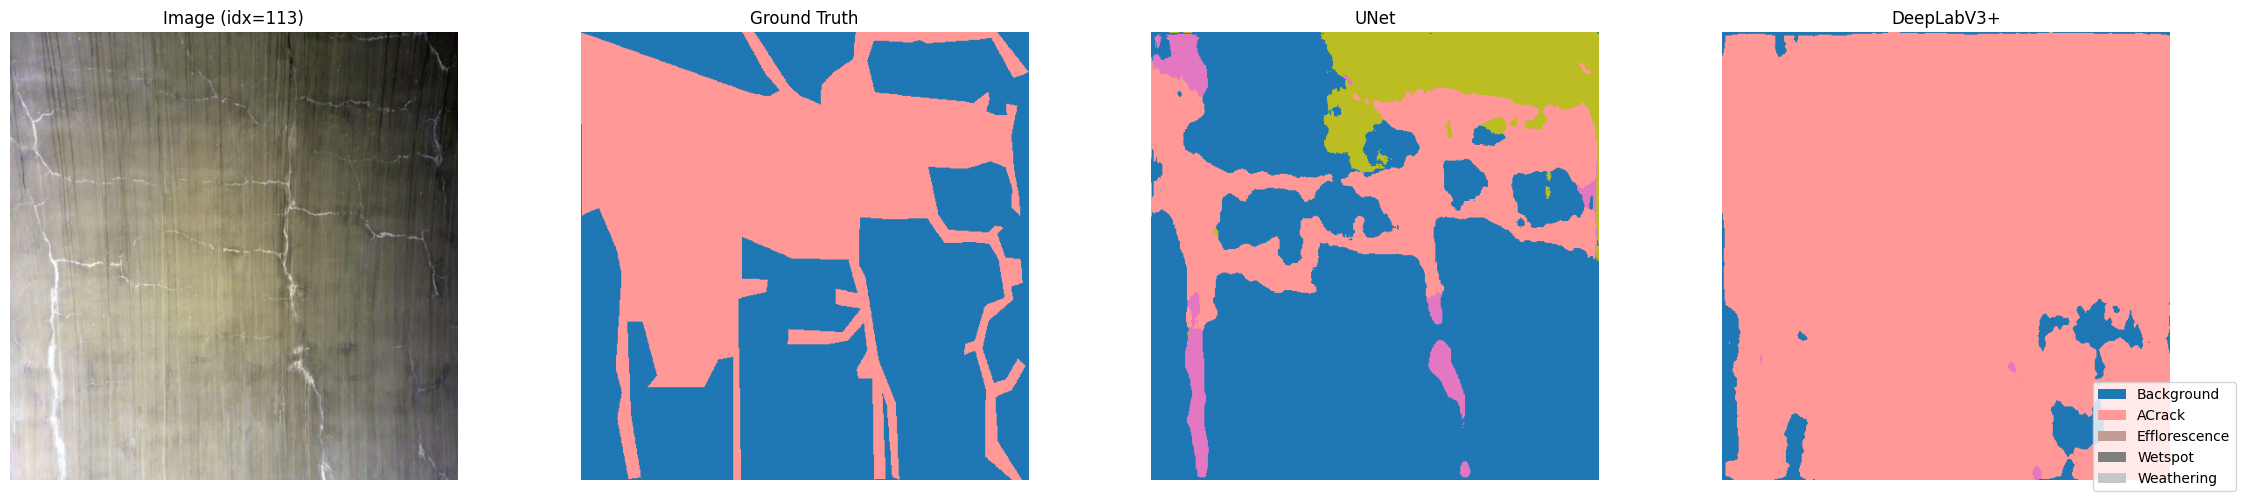

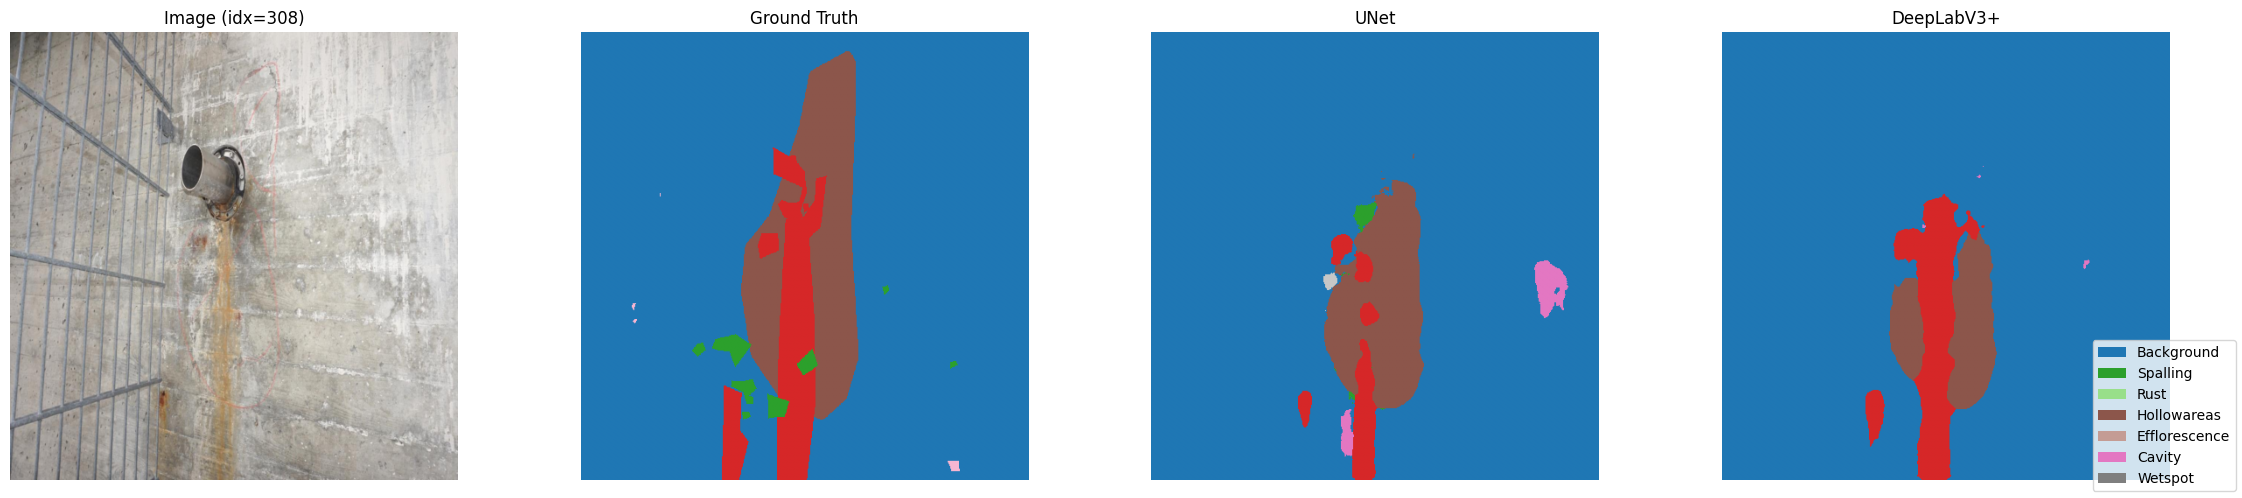

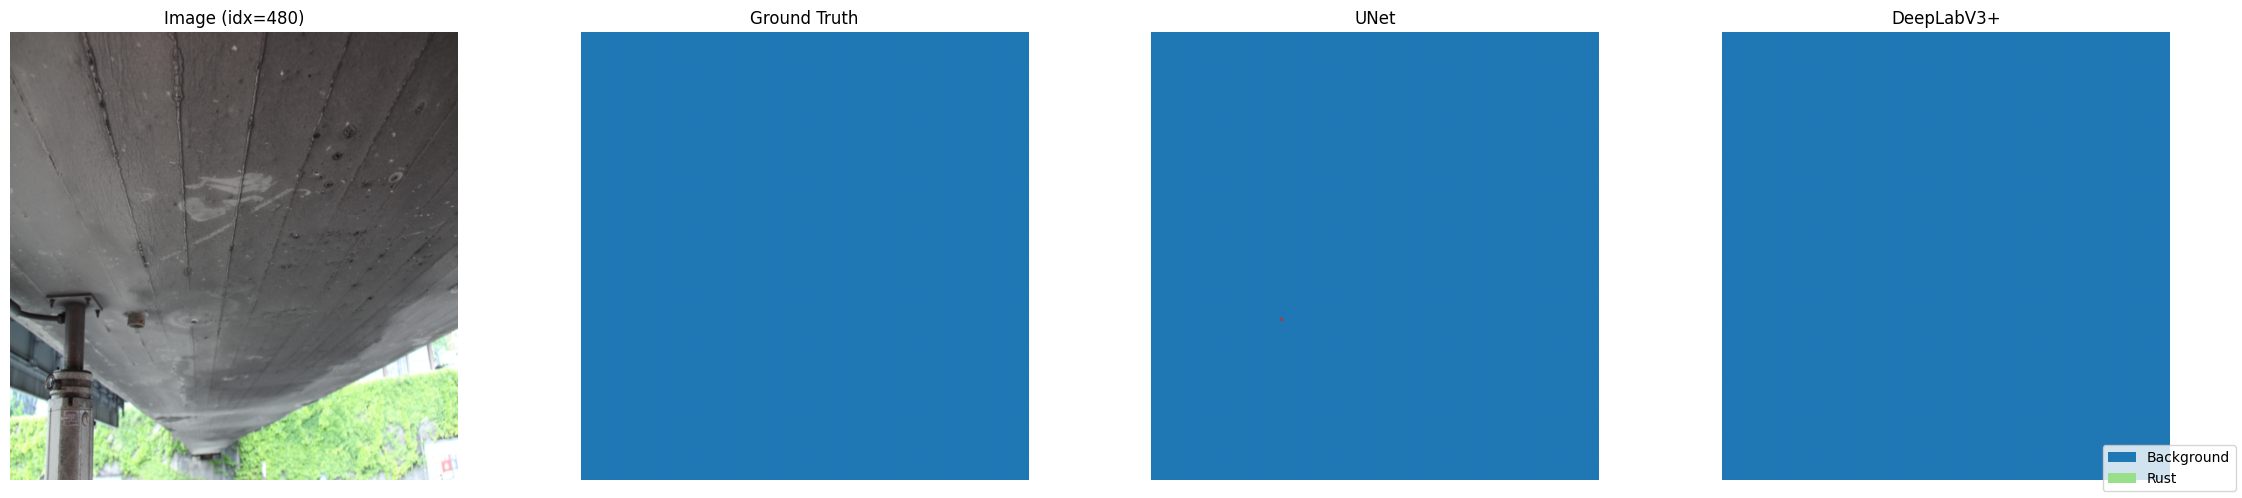

In [138]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

unet.to(device)
deeplab.to(device)

models = {
    "UNet": unet,
    "DeepLabV3+": deeplab,
    # later: "SegFormer-B0": segformer_model,
}

for i in range(5):
    visualize_random_sample_models(models, test_dataset, device, CLASS_NAMES, num_classes=14)


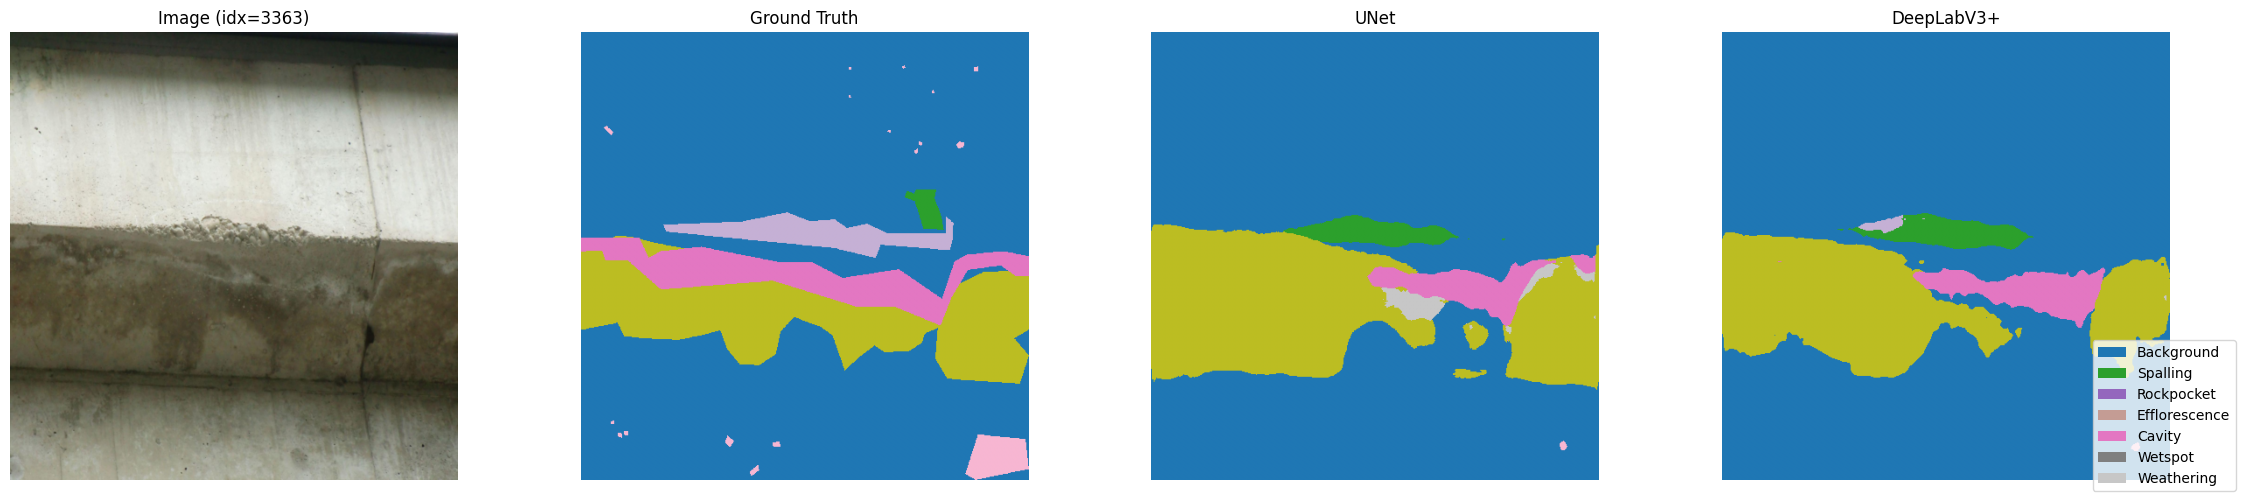

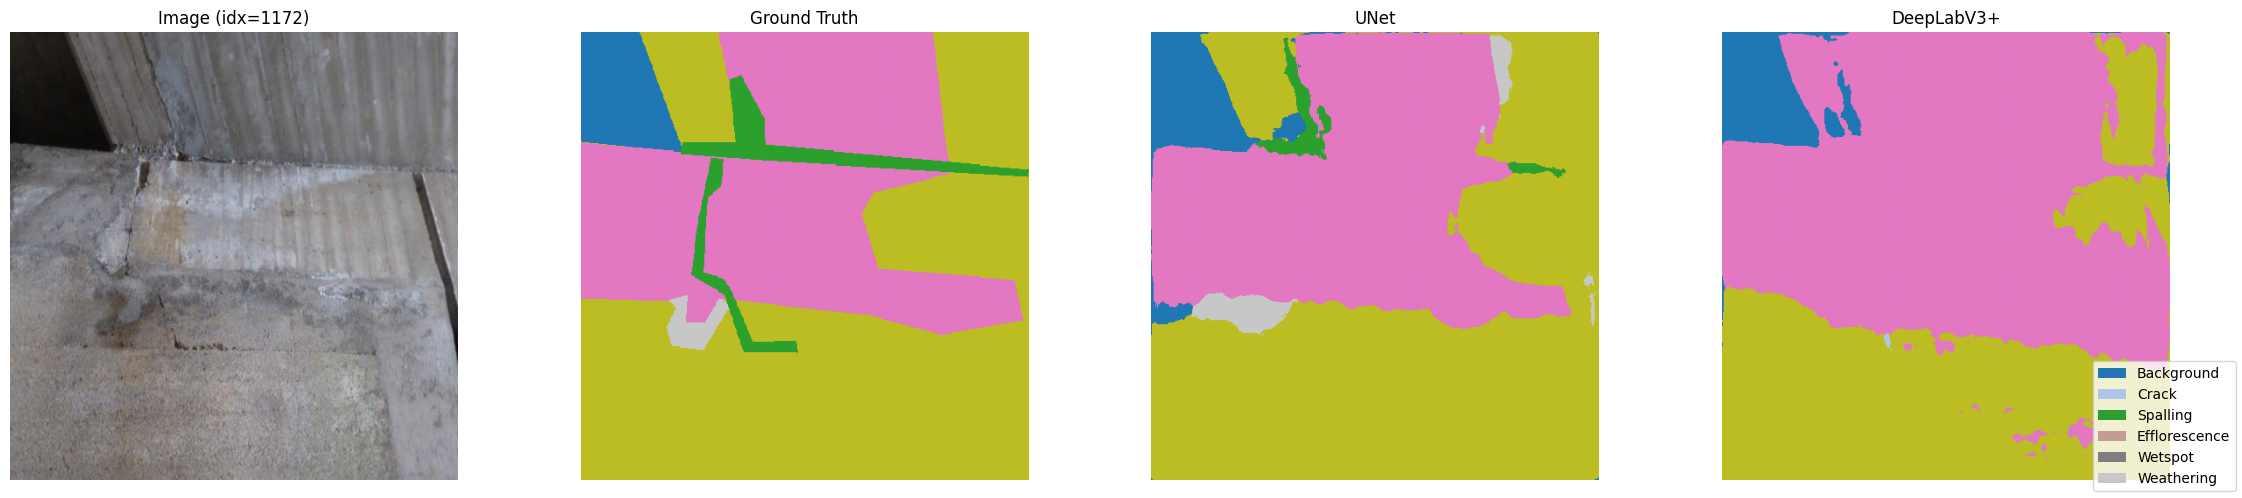

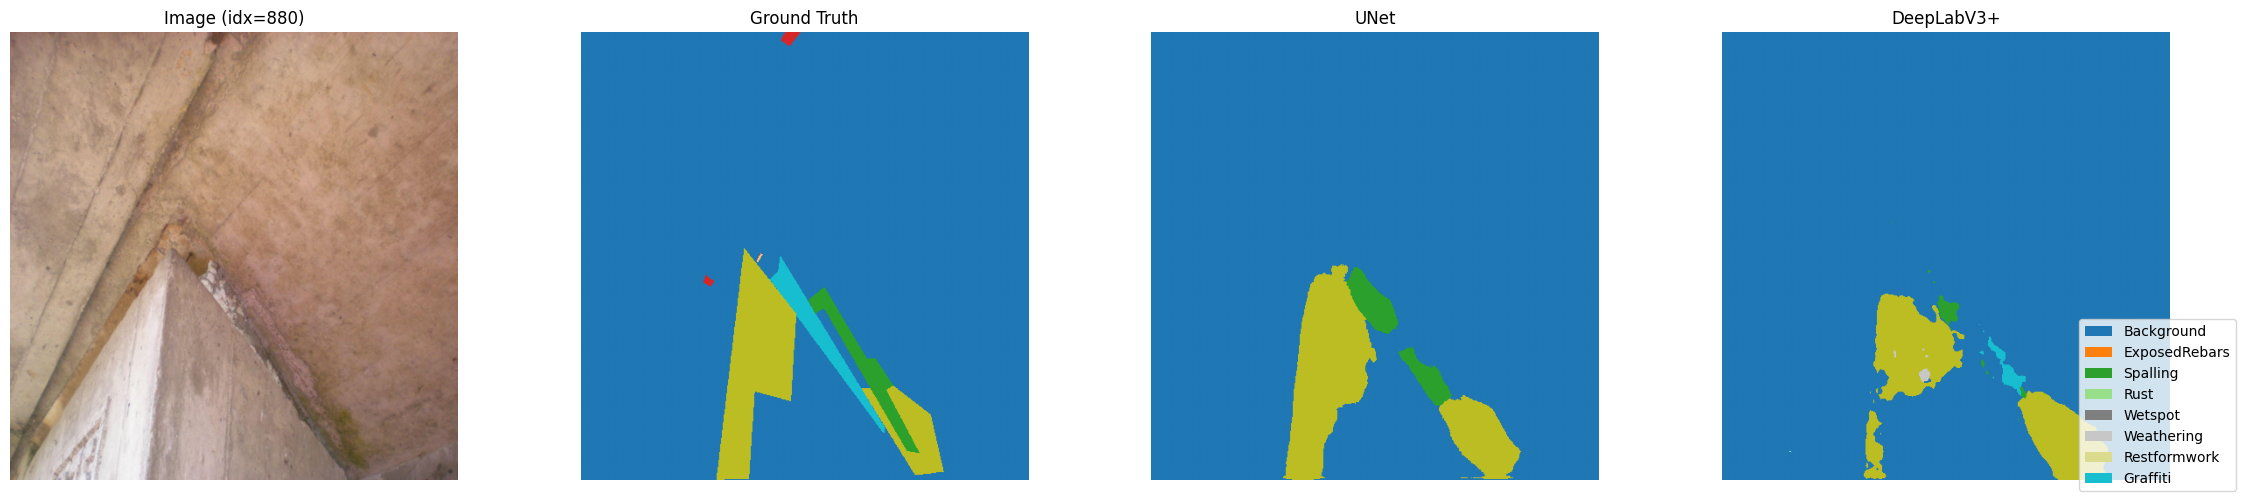

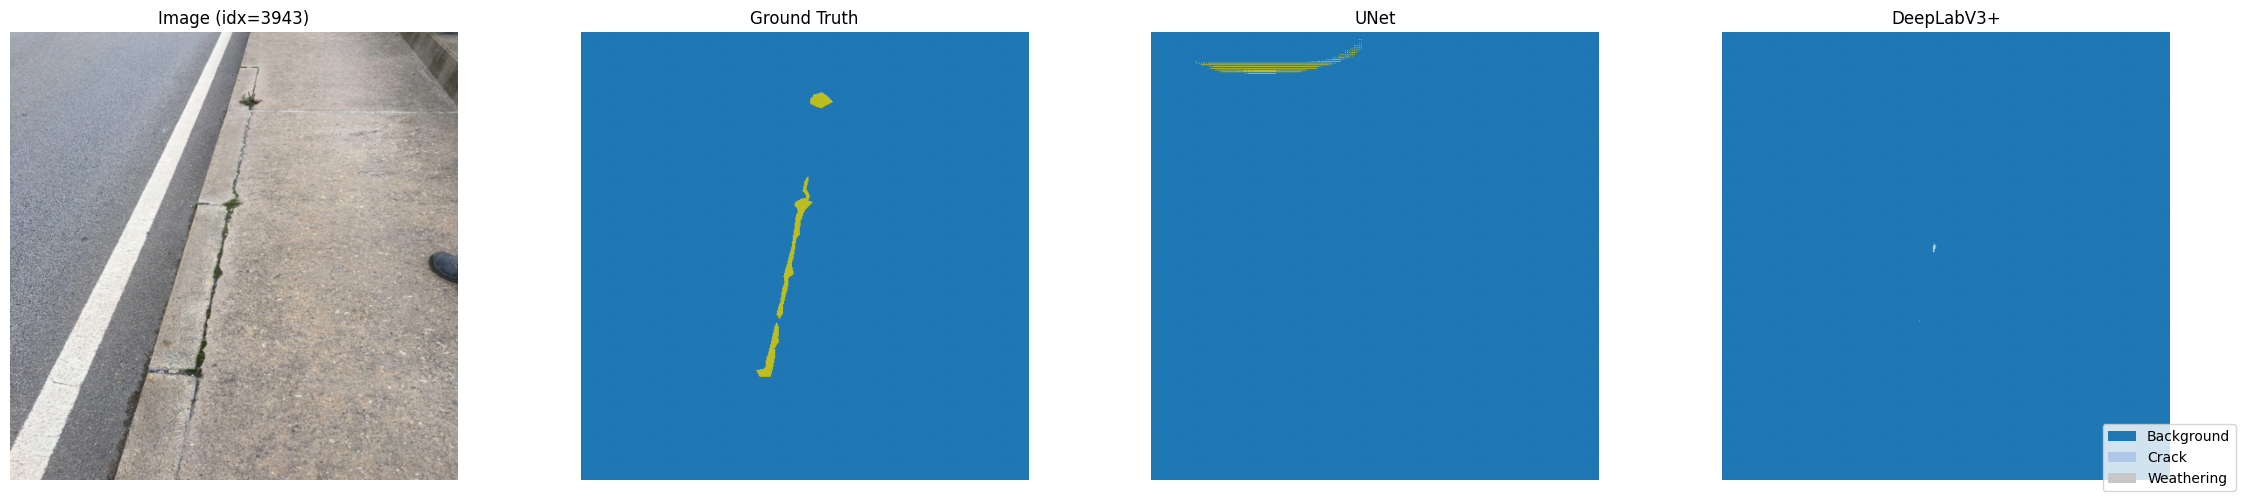

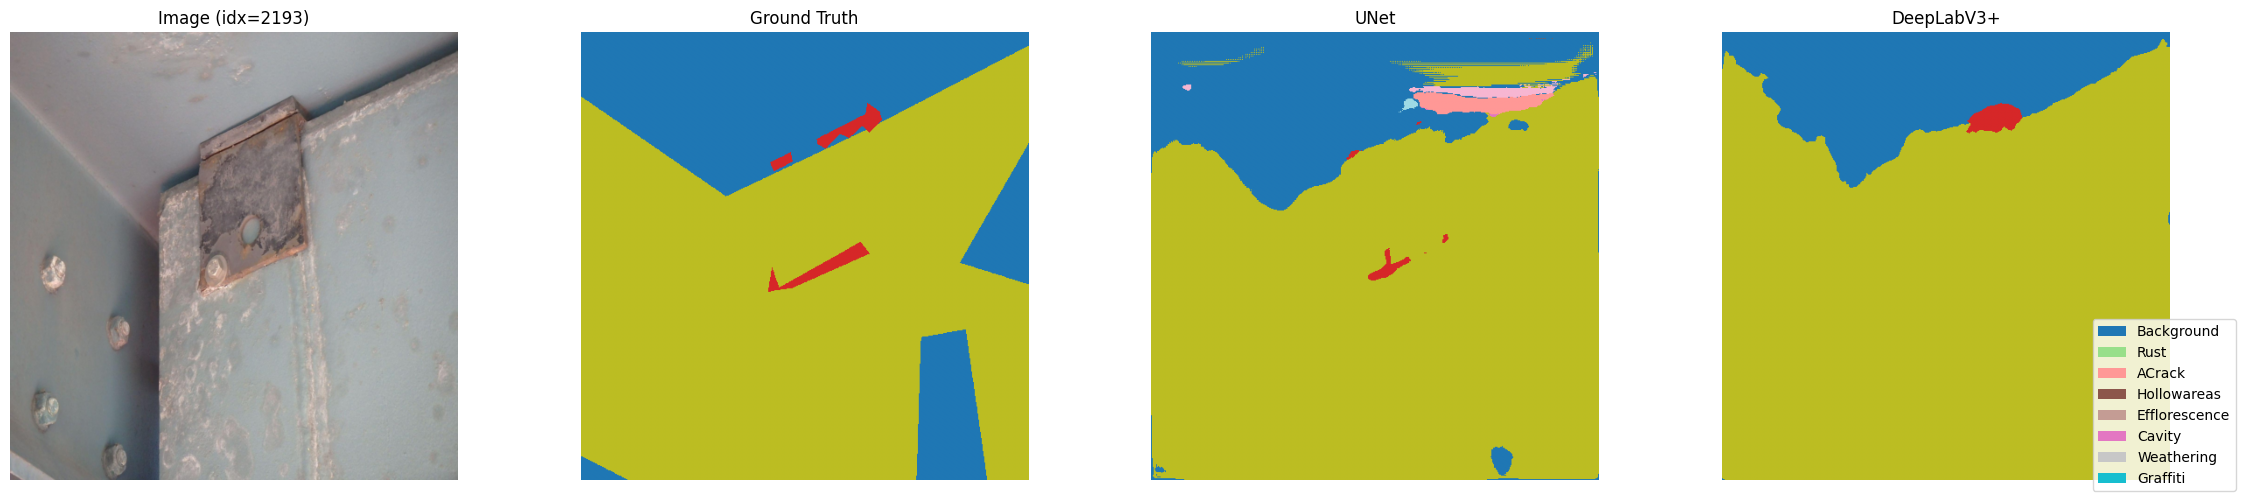

In [142]:
for i in range(5):
    visualize_random_sample_models(models, train_dataset, device, CLASS_NAMES, num_classes=14)